# Stratified KFold+XGBoost+EDA Tutorial
### **Hyungsuk Kang, Sungkyunkwan University**
#### 2017/10/8
# Outline
* **1. Introduction**
* **2. Data preparation**
    * 2.1 Load data
    * 2.2 Check for missing values
    * 2.3 Split features and targets from the data
    * 2.4 Exploratory Visualization
* **3. Training/Predicting Pipeline**
    * 3.1  Define Gini metric
    * 3.2 Drop Unnecessary Features
    * 3.3 Stratified KFold
    * 3.4 XGBoost
* **4. Prediction and submission**
    * 4.1 Predict and Submit results


# **1. Introduction**

This is a full walkthrough for building the machine learning model for Porto Seguro’s Safe Driver Prediction dataset provided by Porto Seguro. Stratified KFold is used due to inbalance of the output variable. XGBoost is used because it is like the winning ticket for classification problem with formatted data. You can check its success on this link. ([XGBoost winning solutions](https://github.com/dmlc/xgboost/tree/master/demo#machine-learning-challenge-winning-solutions)) First, I will prepare the data (driver's information and whether the driver initiated auto insurance or not) then I will focus on prediction.

For more information on XGBoost, click this link.

# [XGBoost](https://xgboost.readthedocs.io/en/latest/)


In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb

# **2. Data Preparation**

## **2.1 Load Data**

In [18]:
train=pd.read_csv('data/train.csv', na_values=-1)
test=pd.read_csv('data/test.csv', na_values=-1)

## 2.2 Check for missing values(NaN)

In [19]:
train.isnull().values.any()

True

### Fill it with median value of the column

this does not harm the distribution of the model

## 2.3 Split features and targets from the data

In [20]:
features = train.drop(['id','target'], axis=1).values
targets = train.target.values

## 2.3 Exploratory Visualization

### Distribution of targets

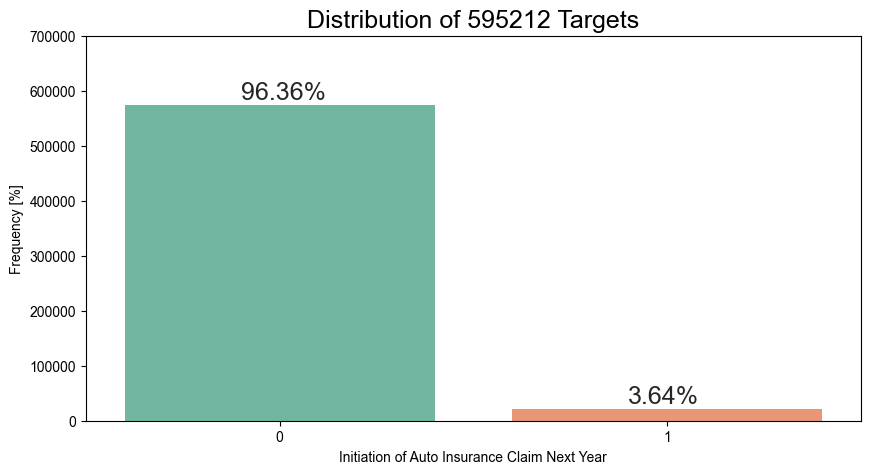

In [21]:
ax = sns.countplot(x = targets ,palette="Set2")
sns.set(font_scale=1.5)
ax.set_xlabel(' ')
ax.set_ylabel(' ')
fig = plt.gcf()
fig.set_size_inches(10,5)
ax.set_ylim(top=700000)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100*p.get_height()/len(targets)), (p.get_x()+ 0.3, p.get_height()+10000))

plt.title('Distribution of 595212 Targets')
plt.xlabel('Initiation of Auto Insurance Claim Next Year')
plt.ylabel('Frequency [%]')
plt.show()

### The plot shows that:
- the target is imbalanced
- high bias is expected to 0
- class weight has to be balanced on training

### Correlation matrix

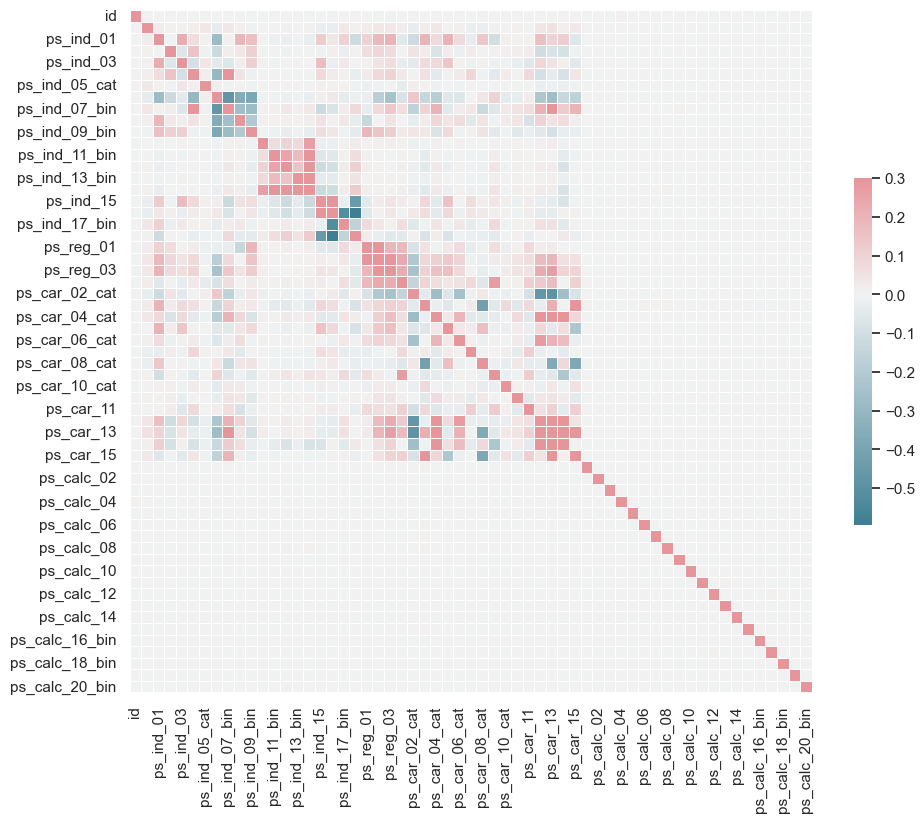

In [22]:
sns.set(style="white")


# Compute the correlation matrix
corr = train.corr()


# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

### It can be seen that:
 - ps\_calc\_\*  features are not related to target at all.
 - Removing them would prevent the curse of dimensionality.
    
    

# 3. Training/Predicting Pipeline

## 3.1 Define Gini Metric

In [23]:
# Define the gini metric - from https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703#5897
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
    
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)
 
def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)

def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = gini_normalized(labels, preds)
    return 'gini', gini_score

## 3.2 Drop Unnecessary Columns

In [24]:
unwanted = train.columns[train.columns.str.startswith('ps_calc_')]


In [25]:
train = train.drop(unwanted, axis=1)  
test = test.drop(unwanted, axis=1)  

## 3.3 Stratified KFold

Stratified KFold is used to keep the distribution of each label consistent for each training batch.

In [26]:
kfold = 5
skf = StratifiedKFold(n_splits=kfold, random_state=42, shuffle=True)

## 3.4. XGBoost

### Set parameters

In [27]:
# More parameters has to be tuned. Good luck :)
params = {
    'min_child_weight': 10.0,
    'objective': 'binary:logistic',
    'max_depth': 7,
    'max_delta_step': 1.8,
    'colsample_bytree': 0.4,
    'subsample': 0.8,
    'eta': 0.025,
    'gamma': 0.65,
    'num_boost_round' : 700
    }

# 4.  Prediction and submission

## 4.1. Predict and Submit results

### Define X and y

In [28]:
X = train.drop(['id', 'target'], axis=1).values
y = train.target.values
test_id = test.id.values
test = test.drop('id', axis=1)

### Create a submission file

This is a pipeline originated from [StratifiedShuffleSplit + XGBoost example (0.28)](https://www.kaggle.com/kueipo/stratifiedshufflesplit-xgboost-example-0-28) 

Original [Simple XGBoost BTB (0.27+)](https://www.kaggle.com/anokas/simple-xgboost-btb-0-27?scriptVersionId=1551232)

In [29]:
sub = pd.DataFrame()
sub['id'] = test_id
sub['target'] = np.zeros_like(test_id)

In [33]:
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    print('[Fold %d/%d]' % (i + 1, kfold))
    X_train, X_valid = X[train_index], X[test_index]
    y_train, y_valid = y[train_index], y[test_index]
    # Convert our data into XGBoost format
    d_train = xgb.DMatrix(X_train, y_train)
    d_valid = xgb.DMatrix(X_valid, y_valid)
    print(X_train.shape, y_train.shape)
    print(type(X_train))
    d_test = xgb.DMatrix(test.values)
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]

    # Train the model! We pass in a max of 1,600 rounds (with early stopping after 70)
    # and the custom metric (maximize=True tells xgb that higher metric is better)
    mdl = xgb.train(params, d_train, 1600, watchlist, early_stopping_rounds=70, custom_metric=gini_xgb, maximize=True, verbose_eval=100)

    print('[Fold %d/%d Prediciton:]' % (i + 1, kfold))
    # Predict on our test data
    print(mdl.best_ntree_limit)
    p_test = mdl.predict(d_test, iteration_range=(0, mdl.best_iteration))
    # p_test = mdl.predict(d_test, ntree_limit=mdl.best_ntree_limit)
    sub['target'] += p_test/kfold

[Fold 1/5]
(476169, 37) (476169,)
<class 'numpy.ndarray'>


C:\Users\DELL\PycharmProjects\Final-Thesis\venv\lib\site-packages\xgboost\core.py:568: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


[14:15:02] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-logloss:0.67259	train-gini:0.05031	valid-logloss:0.67259	valid-gini:0.06085
[100]	train-logloss:0.16518	train-gini:0.31798	valid-logloss:0.16600	valid-gini:0.27587
[200]	train-logloss:0.14966	train-gini:0.35868	valid-logloss:0.15218	valid-gini:0.28400
[300]	train-logloss:0.14746	train-gini:0.39575	valid-logloss:0.15162	valid-gini:0.28959
[400]	train-logloss:0.14606	train-gini:0.42362	valid-logloss:0.15153	valid-gini:0.29089
[495]	train-logloss:0.14492	train-gini:0.44650	valid-logloss:0.15151	valid-gini:0.29067
[Fold 1/5 Prediciton:]
426
[Fold 2/5]
(476169, 37)

In [34]:
mdl.predict(d_test, iteration_range=(0, mdl.best_iteration))

array([0.02828369, 0.02531623, 0.02482584, ..., 0.02992675, 0.02277192,
       0.02814503], dtype=float32)

### Put submission to csv file

In [ ]:
sub.to_csv('StratifiedKFold.csv', index=False)